In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

## Step 1. Open the data file and study the general information

In [ ]:
try:
    cars = pd.read_csv('vehicles_us.csv')
except:
     cars = pd.read_csv('/datasets/vehicles_us.csv')

cars

In [ ]:
cars.info()

## Step 2. Data preprocessing

### — Identify and study missing values:

In [ ]:
cars.isnull().sum()

In [ ]:
cars['model_year'].fillna(cars.groupby('model')['model_year'].transform('mean'), inplace=True)

In [ ]:
cars['cylinders'].fillna(cars.groupby('model')['cylinders'].transform('median'), inplace=True)

In [ ]:
cars['odometer'].fillna(cars.groupby('model_year')['odometer'].transform('mean'), inplace=True)
cars['odometer'].fillna(value=0, inplace=True) #one last nan value was replaced by 0

In [ ]:
cars['paint_color'].fillna(value='N/A', inplace=True)

In [ ]:
cars['is_4wd'].fillna(value=0, inplace=True)

In [ ]:
cars.isnull().sum() # checking if there are still any missing values left

### About missing values:

#### model_year column missing values were replaced by the mean number of years per model.
#### cylinders column missing value were replaced by the median number of the amount of cylinders per model
#### odometer column missing values were replaced by the mean number of the odometer counts per model_year group. after the replacement there were one missing value left. the model_year value related to the car only had one single representant (model_year == 1929), therefore the program was unable to calculate the mean odometer value. It was replaced manually by 0.

#### all of the above columns I considered as MAR values as they could be estimated based on other information provided in the table.

#### paint_color colums missing values were assigned N/A because is not possible to find out the color of each car, even though the models could be exactly equal in all other columns. Moreover, so far, there is no need to know the exact color. MCAR value

#### is_4wd column missing values were assigned 0 (False) because the only other option is True, embracing half of the table. MNAR value.

#### I believe the missing values were so frequent due to  the subject of the the table. These are very solid data that is usually found in every vehicle documents. If the person doesn't have access to these documents, very likely this could be the reason to such missing values.

### — Convert the data to the required types:

In [ ]:
cars['model_year'] = cars['model_year'].astype(int)
cars['cylinders'] = cars['cylinders'].astype(int)
cars['odometer'] = cars['odometer'].astype(int)
cars['is_4wd'] = cars['is_4wd'].astype(int)
cars['date_posted'] = pd.to_datetime(cars['date_posted'], format='%Y-%m-%d')

In [ ]:
cars.dtypes

In [ ]:
cars.duplicated().sum()

#### There is no reason for model_year, cylinders and is_4wd to be floating points since the two first columns show round numbers and the third one shows a boolean value. The odometer column could be a floating point, but is already rounded up to facilitate the reading. They were all converted to integer to match the table and facilitate future manipulations. Also, no duplicate was found

#### date_posted column was converted to datetime datatype to match the next task.

## Step 3. Calculate and add to the table the following:

### Day of the week, month, and year the ad was placed

In [ ]:
cars['date_posted'] = pd.to_datetime(cars['date_posted']).apply(lambda x: pd.datetime.strftime(x,'%d/%m/%y'))
# date rearranged to the correct display
weekday = pd.DatetimeIndex(cars['date_posted']).day_name().astype(str)
month = pd.DatetimeIndex(cars['date_posted']).month_name().astype(str)
year_str = pd.DatetimeIndex(cars['date_posted']).year.astype(str)
year_num = pd.DatetimeIndex(cars['date_posted']).year #different dtype 
# day of the week, month and year were extracted

In [ ]:
cars['ad_placed'] = weekday.str.cat(month, sep=' ')
cars['ad_placed'] = cars['ad_placed'].str.cat(year_str, sep=' ')
cars
# day of the week, month and year converted to strings and ad_placed column created with the required data

## The vehicle's age (in years) when the ad was placed

In [ ]:
cars['car_age'] = year_num - cars['model_year']
#a new column with the vehicle's age was created

### The vehicle's average mileage per year

In [ ]:
cars['mileage'] = (cars['odometer'] / cars['car_age']).round(0)
#new column with the vehicle's average mileage per year was created


In [ ]:
# need to replace mileage inf values with odometer values
cars['mileage'] = np.where(cars['car_age'] == 0,cars.odometer, cars.mileage )

### In the condition column, replace string values with a numeric scale:
### new = 5
### like new = 4
### excellent = 3
### good = 2
### fair = 1
### salvage = 0

In [ ]:
def num_condition(condition):
    if 'new' in condition:
        return 5 
    if 'like new' in condition:
        return 4
    if 'excellent' in condition:
        return 3
    if 'good' in condition:
        return 2
    if 'fair' in condition:
        return 1
    elif 'salvage' in condition:
        return 0
    else:
        return 'Not Applicable' # in case of an outlier

cars['condition'] = cars['condition'].apply(num_condition)
cars['condition'].value_counts() # checks if there is any outliner

In [ ]:
cars.isnull().sum() #checking for new missing values after the creation and modification of 3 columns.

In [ ]:
cars[cars.isna().any(axis=1)] #checking the rows where missing values appears
cars['mileage'].fillna(value=0, inplace=True) #missing values replaced by 0.
#missing values that resulted from the creation of mileage column. model year is the same as the year of the placed ad and the odometer is 0. Brand new vehicle, therefore no mileage value.

## Step 4. Carry out exploratory data analysis, following the instructions below:


### - Study the following parameters: price, vehicle's age when the ad was placed, mileage, number of cylinders, and condition. Plot histograms for each of these parameters. Study how outliers affect the form and readability of the histograms.

### - Determine the upper limits of outliers, remove the outliers and store them in a separate DataFrame, and continue your work with the filtered data.

### Use the filtered data to plot new histograms. Compare them with the earlier histograms (the ones that included outliers). Draw conclusions for each histogram.

### Study how many days advertisements were displayed (days_listed). Plot a histogram. Calculate the mean and median. Describe the typical lifetime of an ad. Determine when ads were removed quickly, and when they were listed for an abnormally long time.

### Analyze the number of ads and the average price for each type of vehicle. Plot a graph showing the dependence of the number of ads on the vehicle type. Select the two types with the greatest number of ads.

### What factors impact the price most? Take each of the popular types you detected at the previous stage and study whether the price depends on age, mileage, condition, transmission type, and color. For categorical variables (transmission type and color), plot box-and-whisker charts, and create scatterplots for the rest. When analyzing categorical variables, note that the categories must have at least 50 ads; otherwise, their parameters won't be valid for analysis.


In [134]:
def raw_data(raw, column, ntitle, yl, xl): #function used to print raw data
    raw = cars.plot(kind='hist', y= column, title = ntitle, ylabel= yl, xlabel = xl)
    print(raw)


def out(outliers, cond): #function used to create an outlier table
    outliers = pd.DataFrame(cars.query(cond))
    print(outliers)

def filtered_data(filtered, cond, column, ntitle, yl, xl): #function used to plot filter data
    filtered = (cars
    .query(cond)
    .plot(kind='hist', y= column, title = ntitle, ylabel= yl, xlabel = xl)
    )
    print(filtered)

AxesSubplot(0.125,0.125;0.775x0.755)


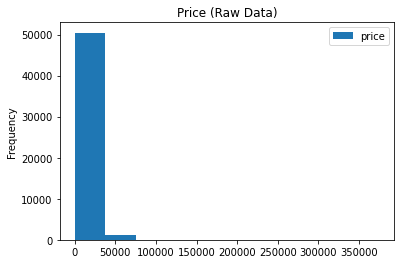

AxesSubplot(0.125,0.125;0.775x0.755)


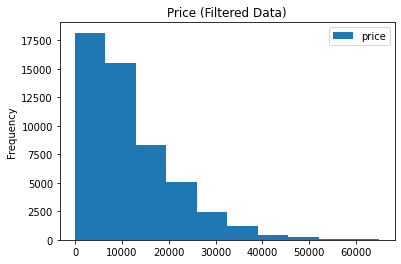

In [136]:
#PRICES TABLES

raw_data('price_raw','price','Price (Raw Data)','Number of vehicles','Prices',)
# out('outliers', 'price > 65000') disabled so the two charts are visible
filtered_data('filtered','price < 65000', 'price','Price (Filtered Data)','Number of vehicles','Prices',)


In [ ]:
#AGE TABLES

raw_data('age_raw','car_age','Age (Raw Data)','Number of vehicles','Age of the vehicles',)
#out('age_outliers', 'car_age > 70') #disabled so the two charts are visible
filtered_data('age_filtered','car_age < 70', 'car_age','Age (Filtered Data)','Number of vehicles','Age',)

In [ ]:
#MILEAGE TABLES
raw_data('mileage_raw','mileage',' Mileage(Raw Data)','Number of vehicles','Mileage',)
#out('mileage_outliers', 'mileage > 130000') #disabled so the two charts are visible
filtered_data('mileage_filtered','mileage <= 130000', 'mileage','Mileage (Filtered Data)','Number of vehicles','Mileage',)

In [ ]:
#CYLINDERS TABLES

raw_data('cylinders_raw','cylinders','Cylinders (Raw Data)','Number of vehicles','Cylinders')

out_cond =  'cylinders == 2 | cylinders == 3 | cylinders == 5 | cylinders == 7 | cylinders == 9 | cylinders > 10'

#out('cylinder_outliers', out_cond) #disabled so the two charts are visible

filt_cond = 'cylinders == 4 | cylinders == 6 | cylinders == 8 | cylinders == 10'
filtered_data('cylinders_filtered',filt_cond, 'cylinders','Cylinders (Filtered Data)','Number of vehicles','Number of Cylinders',)


In [ ]:
#CONDITIONS TABLES
raw_data('condition_raw','condition','Condition (Raw Data)','Number of vehicles','Condition')

cond_cond_out = 'condition < 2'
out(condition_outliers, cond_cond_out)

filtered_data('condition_filtered','condition >= 2', 'condition','Condition (Filtered Data)','Number of vehicles','Different Conditions of the vehicles',)

# conclusion above


## Analyze the number of ads and the average price for each type of vehicle. Plot a graph showing the dependence of the number of ads on the vehicle type. Select the two types with the greatest number of ads.

In [112]:
ads_type = cars.pivot_table(index='type', values='ad_placed', aggfunc='count') #pivot table with the number of ads per vehicle type

price_type = cars.pivot_table(index='type', values='price', aggfunc='mean').round(2) #pivot table with the average price of every vehicle type

types_ad_price = price_type.merge(ads_type, on='type') #merge of the two above tables.
types_ad_price

,price,ad_placed
type,,
SUV,11149.40,12405
bus,17135.67,24
convertible,14575.88,446
coupe,14353.44,2303
hatchback,6868.51,1047
mini-van,8193.18,1161
offroad,14292.29,214
other,10989.71,256
pickup,16057.41,6988


<AxesSubplot:title={'center':'Dependence of the number of ads on the vehicle type'}, xlabel='Type of vehicle', ylabel='Number of ads'>

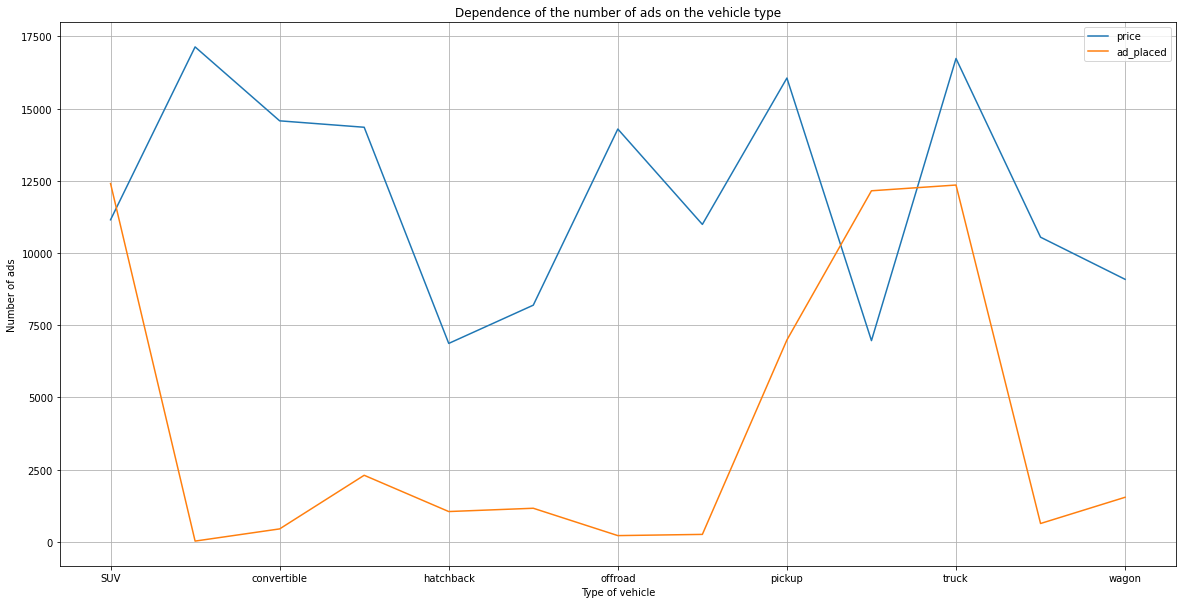

In [175]:
types_ad_price.plot(grid=True, figsize=[20,10], title='Dependence of the number of ads on the vehicle type', ylabel='Number of ads', xlabel='Type of vehicle')


In [151]:
#Select the two types with the greatest number of ads.
types_ad_price['price'].corr(types_ad_price['ad_placed'])
# a very weak/low correlation is presented in the relationship between the 2 columns

0.013684819092332672